# Lab 04 - Clustering


## 0 - Goal of the Workshop
The goal of this workshop is to show the main principles of Clustering, in an interactive and
educational context. We will talk about Clustering basic definitions, Clustering algorithms and methods to evaluate their performance.
Each section contains questions and small exercises to grasp better each of the explained concepts.

## 1 - Introduction

### Supervised Learning VS Unsupervised Learning
***Machine Learning*** is a field of Artificial Intelligence used to make systems learn a specific behaviour (classification, regression, etc...) starting from data. To do so, data can be "labeled" - associated to some extra information like a numerical value or a category - and the involved algorithm is required to learn a mapping from each data input to these labels, an approach called ***Supervised Learning***.
However, sometimes labels are not available, or we want to have insights on the known data rather than getting predictions. ***Unsupervised Learning*** algorithms come in help, since they can learn patterns from unlabeled data, without needing any extra information

### Unsupervised Learning: use cases
Unsupervised Learning can be used in several scenarios:
   - customer segmentation: dividing customers in groups based on purchase history/browsing patterns (without knowing the number of customer types)
   - anomaly detection: revealing data points which deviate significantly from the others
   - document categorization: organizing text documents into categories based on content similarity

### Clustering
***Clustering*** is a type of Unsupervised Learning which consists in finding groups of data objects, called *clusters*, such that elements within the same cluster are similar/related to one another and are different to the ones belonging to other clusters. Actually, the definition of cluster can vary based on the type of algorithm used; some examples:
- ***center-based*** $\rightarrow$ a cluster is the set of objects closest to its center; the center can be defined in several ways, for example as the *centroid* - the average of the points within the relative cluster
    $$
        C_i = (c_{i1}, c_{i2}, ..., c_{in}) ,\quad c_{ij} = \frac{1}{n}\sum\limits_{l=1}^{n}x_{lj}
    $$
    Where $c_ij$ is the j-th component of the cluster i, and $x_lj$ is the j-th component of the l-th point of the cluster i
- ***density-based*** $\rightarrow$ a cluster is a high-density region of points; the separation among clusters is represented by low-density regions

<!--### Question: which among the following are examples of unsupervised learning?
- predicting house prices
- detecting fraudulent transactions
- grouping text documents by topic-->


## 2 - Loading and preparing the Dataset

In [313]:
# import dependencies
from sklearn.datasets import load_iris, load_wine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

***Iris*** is a pretty common dataset containing the description about the types of iris plant. The dataset is made of 3 equally distributed classes, with information about sepal and petal width/length.
### Loading the dataset
We use the method *load_iris()* from *sklearn.datasets* to easily get the dataset as a DataFrame (with the option *as_frame = True*). The returned object contains:
- *data* $\rightarrow$ DataFrame with only feature columns
- *target* $\rightarrow$ Series (one dimensional array holding data of any type) with only the target (class) column
- *frame* $\rightarrow$ DataFrame combining *data* and *target*
- *feature_names* $\rightarrow$ list of the features' names
- *target_names* $\rightarrow$ list of the classes' names

In [314]:
# load the dataset
iris = load_iris(as_frame=True)
# create a DataFrame with only features (no target)
iris_df = iris.data


### Initial feature visualization and distributions
Visualizing the features is fundamental not only to have a general understanding of how the dataset is structured, but also to check if some preprocessing is required or not.

The *display()* method can be used to render a dataset in a tabular format, with rows representing the entries of the dataset and the columns representing the features.

The *describe()* method of a DataFrame object is a statistics function containing a lot of useful information, like:
- *count*: number of non-null values for each column
- *mean*: mean of the values in each column
- *std*: standard deviation of the values in each column

The method *Series.value_counts()* can be used to check the number of samples per class, which can give insights about the dataset distribution.

In [315]:
# feature visualization
display(iris_df)
display(iris_df.describe().T)

class_distribution = iris.target.value_counts().sort_index()
distr_df = pd.DataFrame({
    #'class_index': class_distribution.index,
    'Class_name': [iris.target_names[i] for i in class_distribution.index],
    'class_count': class_distribution.values,
})

display(distr_df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


,Class_name,class_count
0,setosa,50
1,versicolor,50
2,virginica,50


To further analyze the data distribution we can plot histograms, for single-feature distributions, and pairplots, for pairwise-feature distributions:
- histogram $\rightarrow$ *DataFrame.hist()*, specifying the number of bins ("bars" of the histogram)
- pairplot $\rightarrow$ *Seaborn.pairplot()*

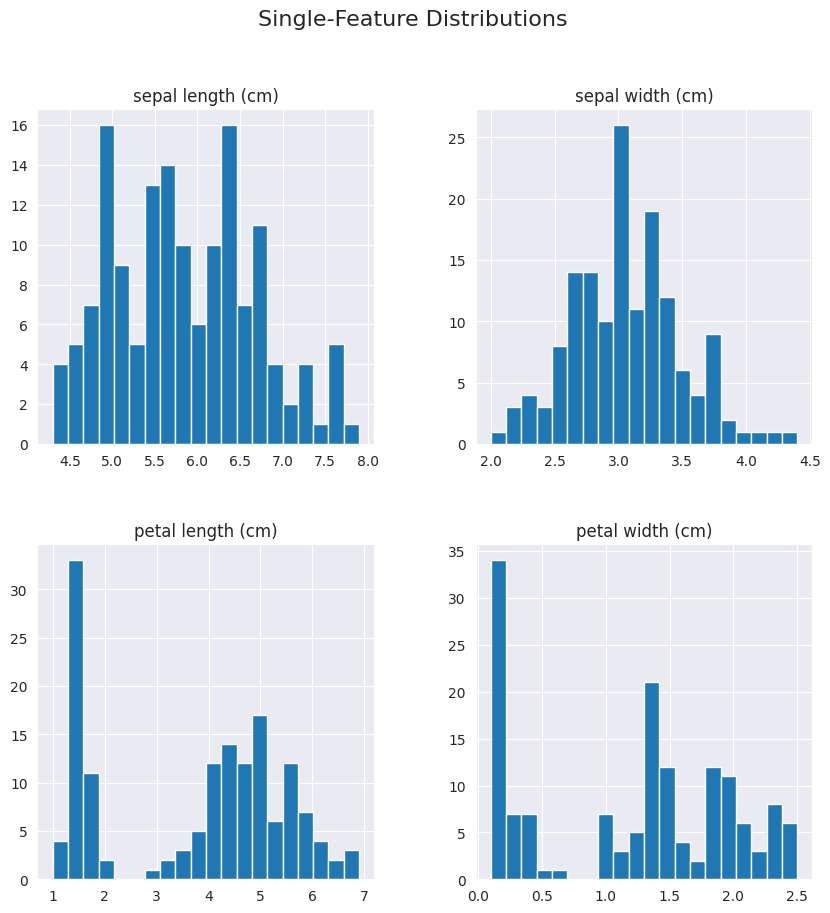

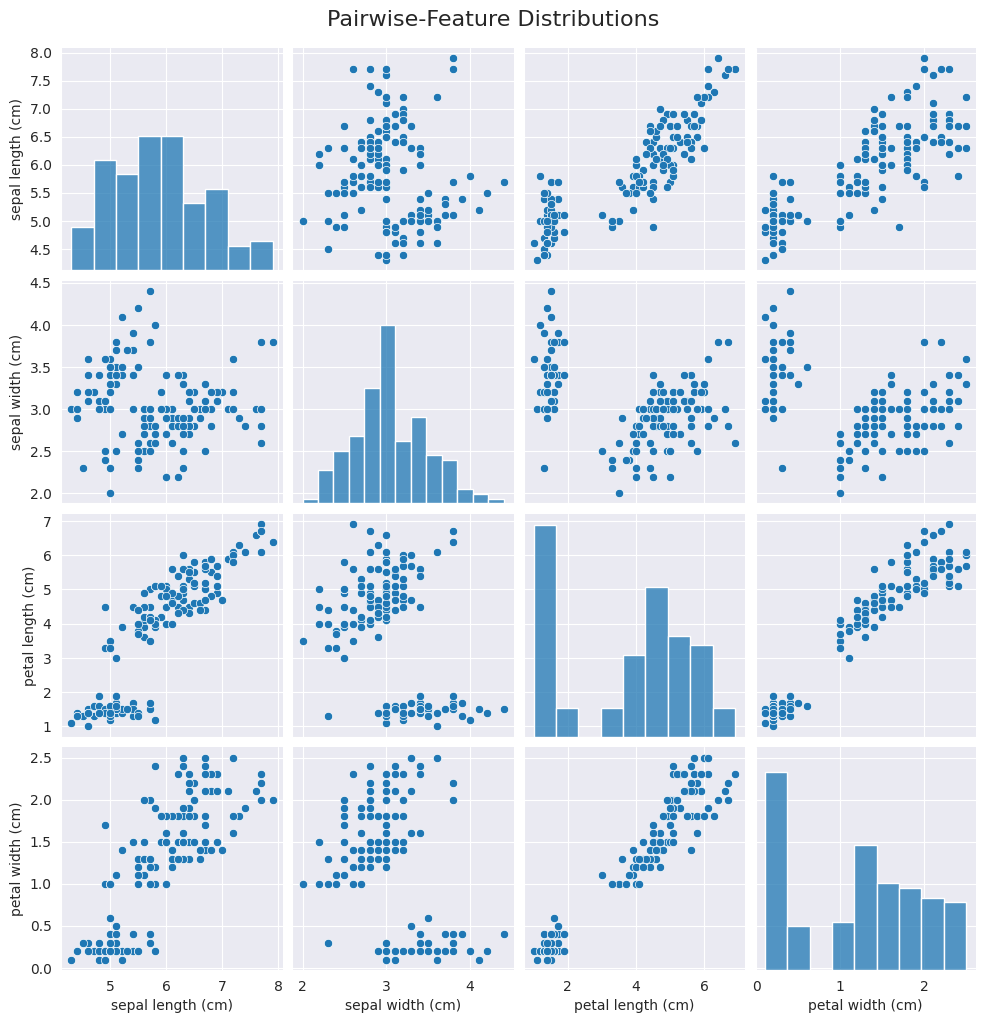

In [316]:
# histogram
iris_df.hist(bins=20, figsize=(10, 10))
plt.suptitle("Single-Feature Distributions", fontsize=16)
plt.show()

# pairplot
sns.pairplot(iris_df)
plt.suptitle("Pairwise-Feature Distributions", fontsize=16, y=1.02)
plt.show()


### The importance of Feature Scaling
Distance-based clusters are sensitive to feature value ranges (distance can be "dominated" by the presence of high values). That's why it's important to scale features before using any clustering algorithm. Since from the previous plots we observe a pseudo-normal trend in almost each feature, we can use *sklearn.preprocessing.StandardScaler()* class, so that each feature has $\approx$ 0 mean and standard deviation equal to 1.
Other possible approaches involve constraining each feature to a fixed range, which we can obtain by using *sklearn.preprocessing.MinMaxScaler()*

In [317]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scale the features
scaler = StandardScaler()
iris_scaled_df = scaler.fit_transform(iris_df)
iris_scaled_df = pd.DataFrame(data=iris_scaled_df, columns=iris.feature_names)

display(iris_scaled_df.describe().T[['mean', 'std', 'min', 'max']])

,mean,std,min,max
sepal length (cm),-4.736952e-16,1.00335,-1.870024,2.492019
sepal width (cm),-7.815970e-16,1.00335,-2.433947,3.090775
petal length (cm),-4.263256e-16,1.00335,-1.567576,1.785832
petal width (cm),-4.736952e-16,1.00335,-1.447076,1.712096


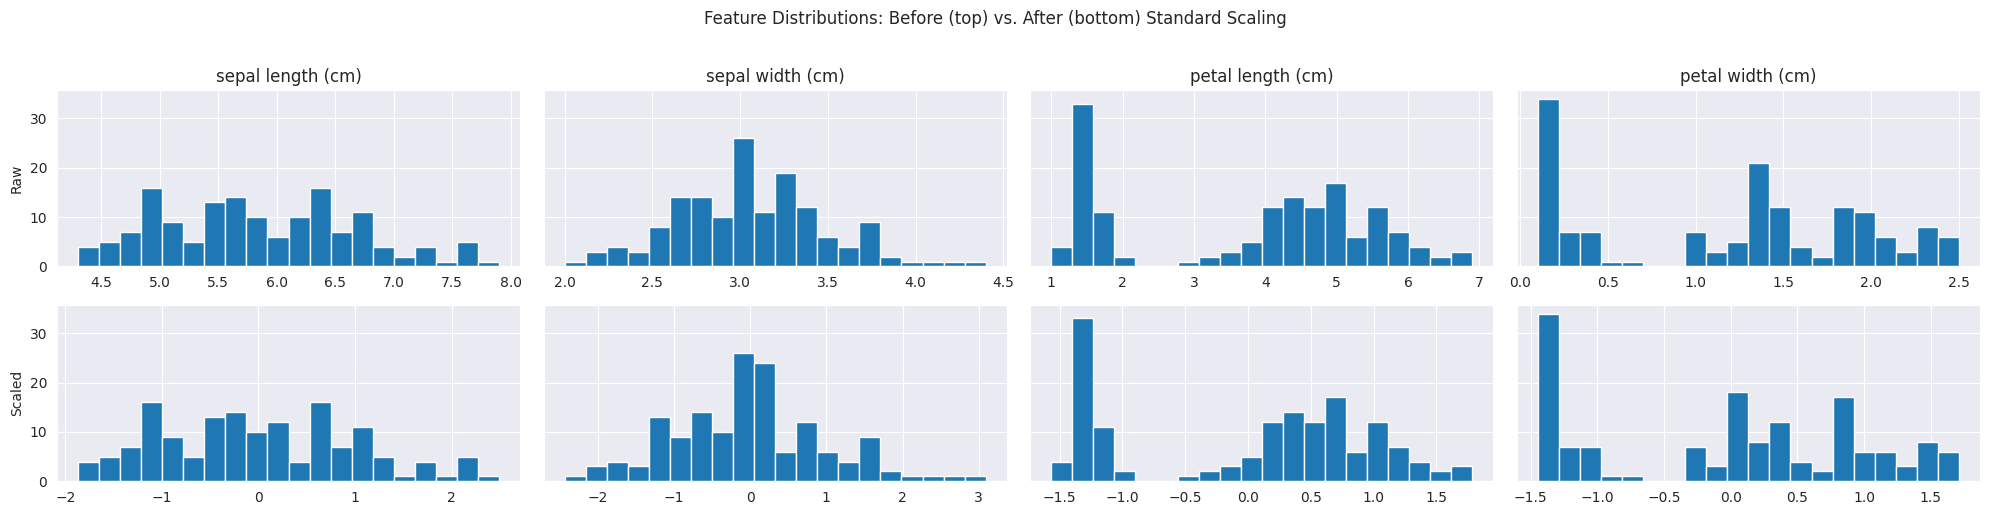

In [318]:
fig, axes = plt.subplots(2, len(iris_df.columns), figsize=(20, 5), sharey='row')

# raw histograms
for i, col in enumerate(iris_df.columns):
    axes[0, i].hist(iris_df[col], bins=20)
    axes[0, i].set_title(col)
    if i==0:
        axes[0, i].set_ylabel('Raw')

# scaled histograms
for i, col in enumerate(iris_scaled_df.columns):
    axes[1, i].hist(iris_scaled_df[col], bins=20)
    if i==0:
        axes[1, i].set_ylabel('Scaled')

fig.suptitle("Feature Distributions: Before (top) vs. After (bottom) Standard Scaling", y=1.02)
plt.tight_layout()
plt.show()

## 3 - Exploring the Data Structure

So far we've seen how to visualize the single features of our dataset, but not how to plot the full data structure, which can be hard if there are more than two features (we would need more than two axes). Dimensionality reduction methods come in help:
- ***PCA (Principal Component Analysis)*** $\rightarrow$ project data points onto the two directions of maximum variance (principal components).
- ***t-SNE (t-Stochastic Neighbor Embedding)*** $\rightarrow$ find embeddings such that two points in the original feature space preserve the same distance in the reduced feature space with high probability
### PCA/t-SNE visualization in Python
We can exploit the two classes *sklearn.decomposition.PCA* and *sklearn.manifold.TSNE*; after calling the constructor, we obtain the reduced dataset with the *fit_transform()* method, and then we visualize it in the feature space with *Seaborn.scatterplot()*

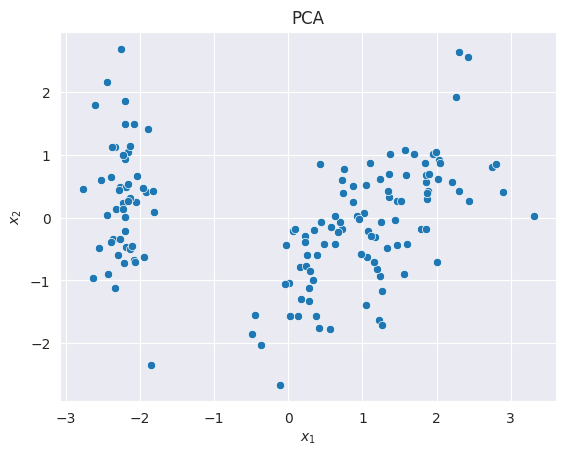

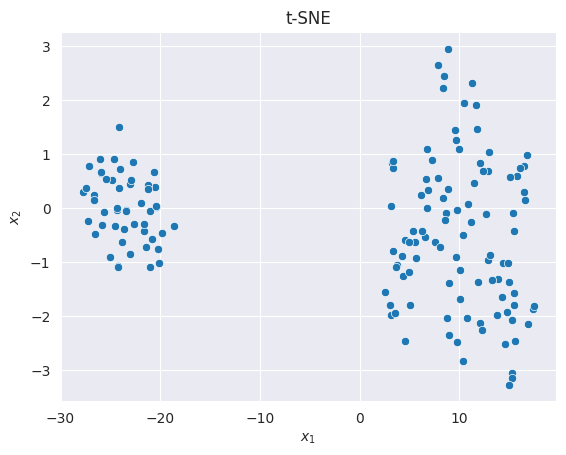

In [319]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA
pca = PCA(n_components=2)
iris_pca = pca.fit_transform(iris_scaled_df)
sns.scatterplot(x=iris_pca[:, 0], y=iris_pca[:, 1])
plt.title("PCA")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=0)
iris_tsne = tsne.fit_transform(iris_scaled_df)
sns.scatterplot(x=iris_tsne[:, 0], y=iris_tsne[:, 1])
plt.title("t-SNE")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

## 4 - Clustering Algorithms
### K-Means
It's a *partitional* clustering algorithm (divides data points in non-overlapping sets such that each point belongs exactly to one set).

**Algorithm steps:**
1) k points are randomly chosen as initial *centroids*, each of them with a relative label
2) each point receives the label corresponding to the nearest centroid
3) centroids are updated using the points with the same label; the process starts again from 2., until convergence

The choice of $k$ is crucial: it determines how many clusters will be formed. Since we have three classes in our dataset, $k$ should be $3$.

### DBSCAN
It's a density-based partitional clustering algorithm. As a density-based method, it doesn't require specifying the number of clusters ($k$ in K-means), since each of them is identified by a high density region in the feature space.

**Algorithm steps:**

0. choose two hyperparameters:
   - *min_samples* $\rightarrow$ minimum number of points to form a dense region
   - $\varepsilon$ $\rightarrow$ neighborhood radius
1. identify *core points* $\rightarrow$ points having more than *min_samples* in their $\varepsilon$-neighborhood
2. identify *border points* $\rightarrow$ points having less than *min_samples* in their $\varepsilon$-neighborhood, but in a $\varepsilon$-neighborhood of a core point
3. identify *noise points* $\rightarrow$ all other points not classified as core or border
4. for each core point, assign to it a label and do the same for all the other points (excluding noise points) in its $\varepsilon$-neighborhood

### DBSCAN - Noise Detection
DBSCAN implicitly performs a noise/outlier detection, since points that are not part of a high density region are labelled with $-1$ and ignored in step 4). By tuning $\varepsilon$ and *min_samples*, we can leverage the level of sparsity and consequently the number of noise points detected



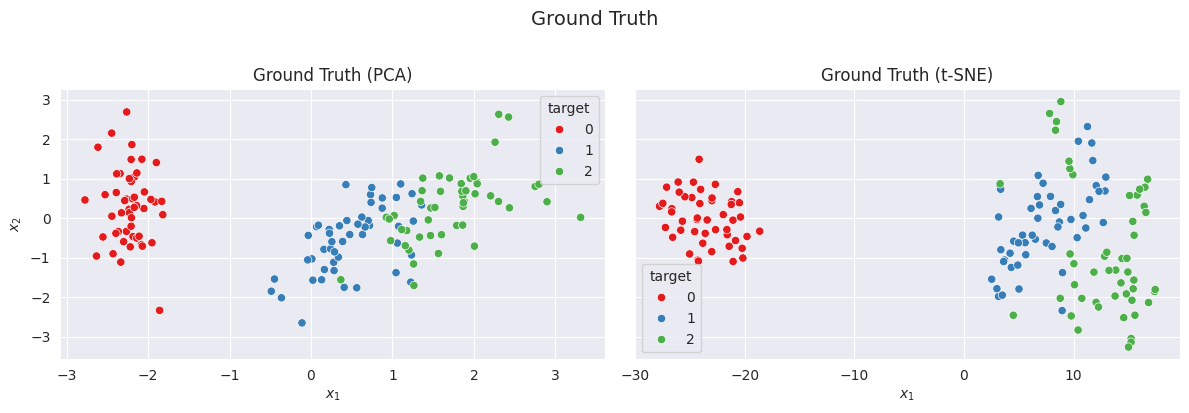

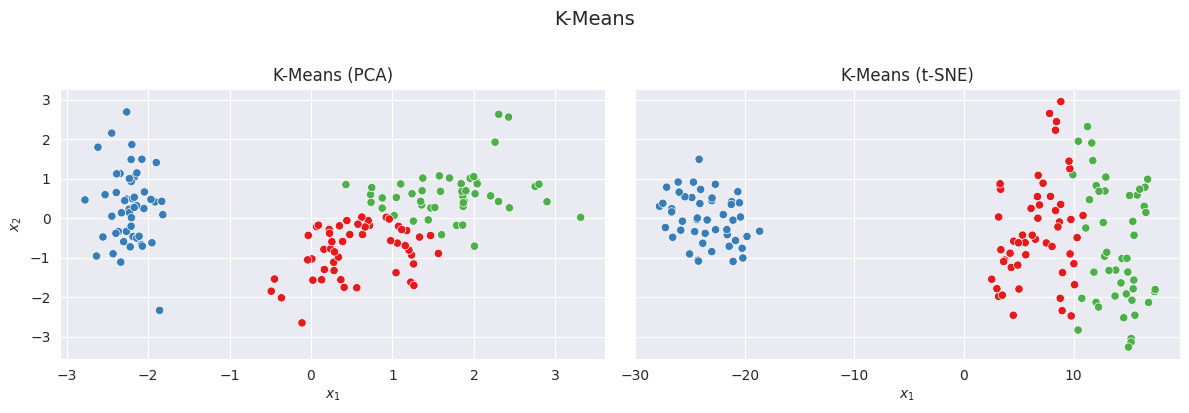

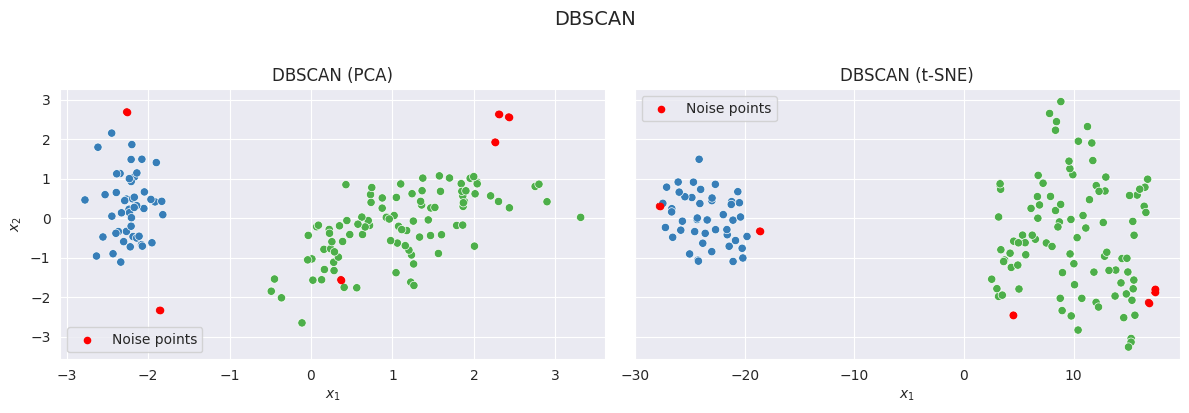

In [320]:
from sklearn.cluster import KMeans, DBSCAN

# K-Means
km = KMeans(n_clusters=3, random_state=0)
kmeans_labels = km.fit_predict(iris_scaled_df) # note that kmeans assigns label numbers randomly, since it does not know true labels

# DBSCAN
dbs = DBSCAN(eps=0.7, min_samples=5)
dbs_labels = dbs.fit_predict(iris_scaled_df)

labelings = {
    "Ground Truth": iris.target,
    "K-Means":      kmeans_labels,
    "DBSCAN":       dbs_labels,
}

for name, labels in labelings.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # PCA subplot
    sns.scatterplot(
        x=iris_pca[:, 0], y=iris_pca[:, 1],
        hue=labels, palette="Set1", ax=axes[0], legend=(name=="Ground Truth")
    )
    axes[0].set_title(f"{name} (PCA)")
    axes[0].set_xlabel("$x_1$")
    axes[0].set_ylabel("$x_2$")

    # t-SNE subplot
    sns.scatterplot(
        x=iris_tsne[:, 0], y=iris_tsne[:, 1],
        hue=labels, palette="Set1", ax=axes[1], legend=(name=="Ground Truth")
    )
    axes[1].set_title(f"{name} (t-SNE)")
    axes[1].set_xlabel("$x_1$")
    axes[1].set_ylabel("$x_2$")

    if name == "DBSCAN":
        noise_mask = (labels == -1)

        # Noise points on PCA
        axes[0].scatter(
            iris_pca[noise_mask, 0], iris_pca[noise_mask, 1],
            c='r', marker='o', s=20, label='Noise points'
        )
        # Noise points on t-SNE
        axes[1].scatter(
            iris_tsne[noise_mask, 0], iris_tsne[noise_mask, 1],
            c='r', marker='o', s=20, label='Noise points'
        )

        axes[0].legend(loc='best')
        axes[1].legend(loc='best')

    plt.suptitle(name, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

### Hierarchical Clustering

In [321]:
# TODO: add Hierarchical clustering and the second part of the Workshop
# TODO: revise first part and add quiz sections
# TODO: think about changing the dataset from Iris to Wine to highlight more the importance of feature scaling